In [1]:
# Run this to download data and prepare our environment!

import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import itertools 

import urllib.request
 
from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import keras

from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")


# Plots the confusion Matrix and save it

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
 
  plt.show()
  plt.close()

def plot_graphs(history, best):
  
  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy across training\n test accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  
  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n test loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [2]:
width, height = 160, 128

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(  
  "C:\\Users\\jaden\\OneDrive\\Documents\\GitHub\\ScienceFair_AI_Models_2023\\jpgTrainingData\\Train",  
  seed=123,  
  image_size = (height, width),
  batch_size = 1, color_mode = "grayscale")

val_ds = tf.keras.utils.image_dataset_from_directory(  
  "C:\\Users\\jaden\\OneDrive\\Documents\\GitHub\\ScienceFair_AI_Models_2023\\jpgTrainingData\\Val",  
  seed=123,  
  image_size = (height, width),
  batch_size = 1, color_mode = "grayscale") 

test_ds = tf.keras.utils.image_dataset_from_directory(  
  "C:\\Users\\jaden\\OneDrive\\Documents\\GitHub\\ScienceFair_AI_Models_2023\\jpgTrainingData\\Test",  
  seed=123,  
  image_size = (height, width),
  batch_size = 1, color_mode = "grayscale")  

Found 90 files belonging to 2 classes.
Found 10 files belonging to 2 classes.
Found 12 files belonging to 2 classes.


In [5]:
cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(height, width, 1), kernel_regularizer=l2(0.01)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation = 'sigmoid'))


In [27]:
#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_cnn_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# compliling the model with adam optimizer and categorical crossentropy loss
cnn_model.compile(loss=binary_crossentropy, optimizer=Adam(lr=1, beta_1=0.9, beta_2=0.999), metrics=['binary_accuracy'])

# training the model
cnn_history = cnn_model.fit(train_ds, validation_data = val_ds, batch_size=1, epochs=6, verbose=1, 
                            callbacks=[checkpoint], shuffle=True)

Epoch 1/6
90/90 [==============================] - ETA: 0s - loss: 463746752.0000 - binary_accuracy: 0.6778
Epoch 1: val_loss improved from inf to 871.13934, saving model to best_cnn_model.h5
90/90 [==============================] - 28s 288ms/step - loss: 463746752.0000 - binary_accuracy: 0.6778 - val_loss: 871.1393 - val_binary_accuracy: 0.7000
Epoch 2/6
90/90 [==============================] - ETA: 0s - loss: 646119424.0000 - binary_accuracy: 0.6667
Epoch 2: val_loss improved from 871.13934 to 870.62170, saving model to best_cnn_model.h5
90/90 [==============================] - 25s 276ms/step - loss: 646119424.0000 - binary_accuracy: 0.6667 - val_loss: 870.6217 - val_binary_accuracy: 0.7000
Epoch 3/6
90/90 [==============================] - ETA: 0s - loss: 363081184.0000 - binary_accuracy: 0.6667
Epoch 3: val_loss improved from 870.62170 to 870.13281, saving model to best_cnn_model.h5
90/90 [==============================] - 25s 273ms/step - loss: 363081184.0000 - binary_accuracy: 0.

In [28]:
#@title Instructor Solution
cnn_performance = cnn_model.evaluate(test_ds, batch_size=1)

12/12 [==============================] - 1s 43ms/step - loss: 868.9346 - binary_accuracy: 0.7500


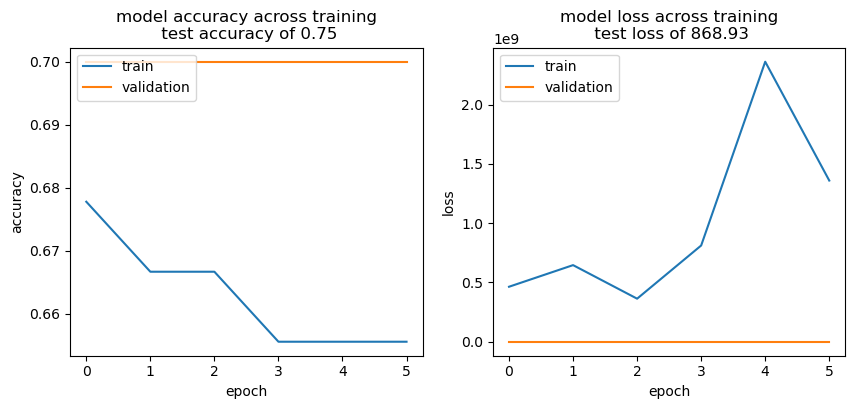

In [29]:
#@title Instructor Solution
plot_graphs(cnn_history, cnn_performance)

In [44]:
img = cv2.imread("C:\\Users\\jaden\\OneDrive\\Documents\\GitHub\\ScienceFair_AI_Models_2023\\jpgTrainingData\\Test\\Drunk\\06_tris_2_e_F_24_51_057.jpg")
img = img[None,:]
print(img.shape)
img = img[:,:,:,0]
model_output = cnn_model.predict(img)
## model_output = model_output * 100
##print(model_output)
model_output = float(model_output[0][0])
print(model_output)
if model_output > 0.5:
    print("Sober")
elif model_output <= 0.5:
    print("Drunk")

(1, 128, 160, 3)
1/1 [==============================] - 0s 57ms/step
0.33912891149520874
Drunk
